## Sentiment Classification with Logistic Regression
Yingzi Jin


### Task
- **Goal**:
    
    In this project, I will practice supervised learning by training a binary classification model to identify whether a tweet about FIFA 2022 World Cup is positive or negative.

- **Chapters**:
    1. Data <br>
        1.1 Data Exploration <br>
        1.2 Data Preprocessing
    
    2. Model <br>
        2.1 Model Introduction <br>
        2.2 Model Training & Tuning <br>
        2.3 Model Performance
    
    3. Result Analysis <br> 
        3.1 Model Performance Interpretation <br>
        3.2 Error Analysis
    

    

### Import Libraries

In [1]:
import pandas as pd
import numpy as np
import re
import contractions
import nltk
import matplotlib.pyplot as plt

### DATA

#### 1.1 Data Exploration

Data Source: https://www.kaggle.com/datasets/tirendazacademy/fifa-world-cup-2022-tweets

Content: Tweets from the first day of the FIFA World Cup 2022




In [2]:
# load dataset as pandas dataframe
df = pd.read_csv("fifa_world_cup_2022_tweets.csv")

Original Data Size: 22524 rows, 6 features

In [3]:
df.shape

(22524, 6)

In [4]:
# first five rows of the dataframe
df.head()


,Unnamed: 0,Date Created,Number of Likes,Source of Tweet,Tweet,Sentiment
0,0,2022-11-20 23:59:21+00:00,4,Twitter Web App,What are we drinking today @TucanTribe \n@MadB...,neutral
1,1,2022-11-20 23:59:01+00:00,3,Twitter for iPhone,Amazing @CanadaSoccerEN #WorldCup2022 launch ...,positive
2,2,2022-11-20 23:58:41+00:00,1,Twitter for iPhone,Worth reading while watching #WorldCup2022 htt...,positive
3,3,2022-11-20 23:58:33+00:00,1,Twitter Web App,Golden Maknae shinning bright\n\nhttps://t.co/...,positive
4,4,2022-11-20 23:58:28+00:00,0,Twitter for Android,"If the BBC cares so much about human rights, h...",negative


In [5]:
# last five rows of the dataframe
df.tail()

,Unnamed: 0,Date Created,Number of Likes,Source of Tweet,Tweet,Sentiment
22519,22519,2022-11-20 00:00:21+00:00,1,Twitter Web App,Here We go World cup 2022 #WorldCup2022,positive
22520,22520,2022-11-20 00:00:03+00:00,0,DenetPro,Anderlecht confirms former Viborg FF's Jesper ...,neutral
22521,22521,2022-11-20 00:00:01+00:00,2,Twitter for iPhone,Great thread to read before the start of #Worl...,positive
22522,22522,2022-11-20 00:00:00+00:00,11,Twitter Web App,Raphinha wants Brazil to be united at the #Wor...,positive
22523,22523,2022-11-20 00:00:00+00:00,24,Twitter Web App,How to buy $SOT on PinkSale?🤔\n\nHave you been...,neutral


In [6]:
# number of rows labeled as positive
df[df['Sentiment'] == 'positive'].shape

(8489, 6)

In [7]:
# number of rows labeled as negative
df[df['Sentiment'] == 'negative'].shape

(5784, 6)

In [8]:
df[df['Sentiment'] == 'neutral'].shape

(8251, 6)

<AxesSubplot:>

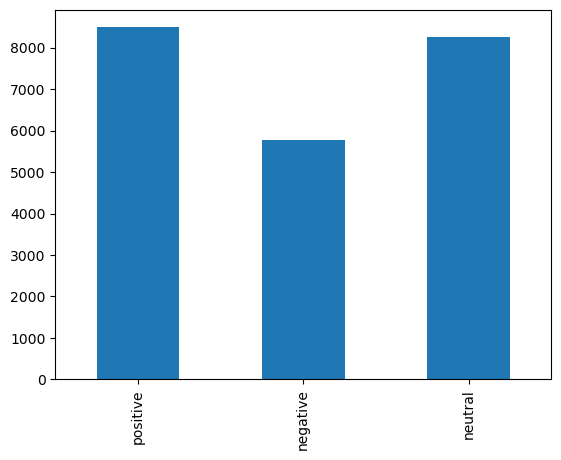

In [24]:
plotdata = pd.DataFrame({'num': [8489, 5784, 8251]}, index=['positive', 'negative', 'neutral'])
plotdata['num'].plot(kind='bar')

Based on the examples above, we can see that the six features of this dataset are the following:

1. Index (numerical)
2. Date Created (categorical)
3. Number of Likes (numerical)
4. Source of Tweet (categorical)
5. Tweet (text)
6. Sentiment (categorical)

There are 8489 tweets are labeled as positive, 5784 as negative, and 8251 as neutral.

#### 1.2 Data Preprocessing

1.2.1 Extract the information that will be used <br>
- In this project, only the tweets and the sentiments labeled to tweets will be used.
- Additionally, although the labeled sentiments have three categories (positive, neutral, and negative), it is essentially a binary classification task. Therefore, we only need to keep rows labeled as positive or negative.


In [13]:
# extract the columns that will be used 
df = df[['Tweet', 'Sentiment']]

In [14]:
# extract rows labeled as positive or negative 
df = df[df['Sentiment'] != 'neutral']

1.2.2. Check and remove null value 

In [15]:
# check null values
df.isnull().sum()

Tweet        0
Sentiment    0
dtype: int64

We can see that there is no null value in our dataframe. Therefore, we do not need to remove any rows.

1.2.3. Convert categorical sentiment to numerical 
- The value of the targeted column should be converted to numerical for model application later.
- 1 represents positive, 0 represents negative

In [16]:
df['Sentiment'].replace(['negative', 'positive'], [0, 1], inplace=True)

In [17]:
# check the dataframe 
df.head()

,Tweet,Sentiment
1,Amazing @CanadaSoccerEN #WorldCup2022 launch ...,1
2,Worth reading while watching #WorldCup2022 htt...,1
3,Golden Maknae shinning bright\n\nhttps://t.co/...,1
4,"If the BBC cares so much about human rights, h...",0
5,"And like, will the mexican fans be able to scr...",0


1.2.4. Text cleaning
- Tweets contain a lot of information that is either not relevent to the content (e.g., @user, urls, ...) or too messy to be processed later (e.g., punctuations, contractions, ...)
- In this sections, we will clean the text based on the following rules:
    - Remove @user, urls, #hashtags, emojis, punctuations, numbers
    - Fix contractions (e.g., "can't" -> "cannot")

In [18]:
# make all text lowercase
tweet = df['Tweet'].str.lower()
clean_text = []

# clean text
for t in tweet:
    # remove \n
    clean_t = re.sub(r"\n", " ", t)
    # remove @account
    clean_t = re.sub(r"@[^\s]+", "", clean_t)
    # remove hashtag
    clean_t = re.sub(r"#[^\s]+", "", clean_t)
    # remove urls
    clean_t = re.sub(r"(www[^\s]+) | (http[^\s]+)", "", clean_t)
    # remove &amp
    clean_t = re.sub(r"&amp", "", clean_t)
    # fix contractions
    clean_t = contractions.fix(clean_t)
    # remove punctuations
    clean_t = re.sub("[^a-z0-9]", " ", clean_t)
    # remove numbers
    clean_t = re.sub(r"\d+", "", clean_t)
   
    clean_text.append(clean_t)

In [19]:
# add cleaned text into our dataframe
df["clean_tweet"] = clean_text
df.head()

,Tweet,Sentiment,clean_tweet
1,Amazing @CanadaSoccerEN #WorldCup2022 launch ...,1,amazing launch video shows how much the fa...
2,Worth reading while watching #WorldCup2022 htt...,1,worth reading while watching
3,Golden Maknae shinning bright\n\nhttps://t.co/...,1,golden maknae shinning bright
4,"If the BBC cares so much about human rights, h...",0,if the bbc cares so much about human rights h...
5,"And like, will the mexican fans be able to scr...",0,and like will the mexican fans be able to scr...


In [92]:
df[['clean_tweet', 'Sentiment']].head()

,clean_tweet,Sentiment
1,amazing launch video shows how much the fa...,1
2,worth reading while watching,1
3,golden maknae shinning bright,1
4,if the bbc cares so much about human rights h...,0
5,and like will the mexican fans be able to scr...,0


1.2.5. Text transformation
- Tokenization
    - It is a process that converts a text string to a list of tokens (which is the smallest unit of machine learning)
- Lemmentization
    - It is to use lexical based knowledge to get the base forms of words instead of simply chop off inflections. 

In this project, I will be using tokenization and lemmentization to break down texts. The reason why lemmentization is preferred rather than stemming is that stemming is more likely to produce non-sense tokens, while lemmentization follows lexical rules. 

In [25]:
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer 

In [44]:
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to /Users/axyz1220/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/axyz1220/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/axyz1220/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

Here, I create two functions where the first one is to simply tokenize the text, while the second one is to tokenize the text with lemmentization.

In [26]:
def tokenizer(text):
    """
    Tokenize text.
    Inputs: text, a string
    Returns: a list of tokens (str)
    """
    return nltk.word_tokenize(text)


def tokenizer_lemmatizer(text):
    """
    Tokenize text with lemmatization.
    Inputs: text, a string
    Returns: a list of lemmatized tokens (str)
    """
    lemmatizer = WordNetLemmatizer()
    return [lemmatizer.lemmatize(tok) for tok in nltk.word_tokenize(text)]

We can take the first tweet in our dataframe as an example. The difference in the result of tokenizer and tokenizer_lemmatizer is that "shows" in the first result becomes "show" in the second one.

In [28]:
text = df['clean_tweet'].iloc[0]

In [30]:
print(tokenizer(text))

['amazing', 'launch', 'video', 'shows', 'how', 'much', 'the', 'face', 'of', 'canada', 'and', 'our', 'men', 's', 'national', 'team', 'have', 'changed', 'since', 'our', 'last', 'world', 'cup', 'entry', 'in', 'can', 'not', 'wait', 'to', 'see', 'these', 'boys', 'in', 'action', 'this', 'is', 'canada', 'fifa', 'world', 'cup', 'opening', 'video']


In [31]:
print(tokenizer_lemmatizer(text))

['amazing', 'launch', 'video', 'show', 'how', 'much', 'the', 'face', 'of', 'canada', 'and', 'our', 'men', 's', 'national', 'team', 'have', 'changed', 'since', 'our', 'last', 'world', 'cup', 'entry', 'in', 'can', 'not', 'wait', 'to', 'see', 'these', 'boy', 'in', 'action', 'this', 'is', 'canada', 'fifa', 'world', 'cup', 'opening', 'video']


1.2.6 Text vectorization 
- TfidfVectorizer
    - The reason why TfidfVectorizer is preferred here than CountVectorizer is that our data is about a specific event, 2022 World Cup. Thus, there will be a lot of words that occur very frequently but do not carry much information. TfidfVectorizer can adjust the frequency of word accross all tweets. 
- In this section, we can get an overview of the features and their frequency in our text data.


In [32]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [33]:
vectorizer = TfidfVectorizer()

In [34]:
X = vectorizer.fit_transform(df['clean_tweet'])

In [37]:
X.shape

(14273, 12651)

In [41]:
# this function is from Quiz 1.2
def get_topn_features(X, feature_names, topn=10):
    """
    Inputs:
        X: feature matrix
        feature_names: extracted features during vectorization
        topn: the number of most frequent features to return
    Outputs:
        topn most frequent features and their frequency
    """
    feature_ct = np.asarray(np.sum(X, axis=0)).reshape(-1)

    feature_freq = []
    
    for i in np.argsort(feature_ct)[::-1][:topn]:
        feature_freq.append({'feature':feature_names[i], 'frequency':feature_ct[i]})
    
    return pd.DataFrame(feature_freq)

In [42]:
feature_names = vectorizer.get_feature_names_out()

In [43]:
get_topn_features(X, feature_names, topn=20)

,feature,frequency
0,the,931.972693
1,is,612.077512
2,to,502.920265
3,world,457.568559
4,cup,430.535453
5,of,420.565892
6,in,395.599261
7,and,386.555279
8,for,377.743904
9,it,366.627375


Here, we can see that most of the top 20 frequent words are not meaningful in terms of sentiment. Therefore, we should generate an appropriate list of stop words to handle this issue. We first apply stopwords list created by nltk.

In [45]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/axyz1220/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [48]:
from nltk.corpus import stopwords

In [49]:
stop = stopwords.words('english')

In [50]:
# take a look at the stopwords
print(stop)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

We can see there are a lot of negation words in the stopwords list. Since we are doing sentiment analysis, removing negations can dramatically change the performance of our model. Therefore, we should remove those negation words from the stopwords list.  

In [51]:
# remove negations in stopwords
for word in stop:
    if "n't" in word:
        stop.remove(word)
stop.remove('not')

In [52]:
# apply our tokenizer_lemmatizer and stop_words to the vectorizer 
vectorizer = TfidfVectorizer(tokenizer=tokenizer_lemmatizer, stop_words=stop)

In [53]:
X = vectorizer.fit_transform(df['clean_tweet'])

/Users/axyz1220/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ["'d", "'ll", "'re", "'s", "'ve", 'doe', 'ha', 'wa'] not in stop_words.
  warnings.warn(


This warning suggests that there is inconsistency in the stopwords between vectorizer and our tokenizer_lemmatizer. Therefore, we should add those tokens generated from stopwords but not included to the stopwords list. 

In [54]:
stop.extend(["'d", "'ll", "'re", "'s", "'ve", 'doe', 'ha', 'wa'])

In [55]:
vectorizer = TfidfVectorizer(tokenizer=tokenizer_lemmatizer, stop_words=stop)
X = vectorizer.fit_transform(df['clean_tweet'])
feature_names = vectorizer.get_feature_names_out()

In [60]:
get_topn_features(X, feature_names, topn=20)

,feature,frequency
0,world,520.925137
1,cup,490.527128
2,qatar,396.441419
3,not,387.314201
4,goal,264.115610
5,go,255.388905
6,let,254.937579
7,u,247.735020
8,offside,227.572605
9,opening,223.143624


We can see there is a "u" in the top 20 list, and we know that it represents you, a stopword. Therefore, add "u" into stopword list. 

In [61]:
stop.append('u')

In [62]:
vectorizer = TfidfVectorizer(tokenizer=tokenizer_lemmatizer, stop_words=stop)
X = vectorizer.fit_transform(df['clean_tweet'])
feature_names = vectorizer.get_feature_names_out()

In [63]:
get_topn_features(X, feature_names, topn=20)

,feature,frequency
0,world,522.261206
1,cup,491.808768
2,qatar,397.141845
3,not,387.684780
4,let,275.187483
5,go,268.790459
6,goal,264.389764
7,offside,227.620770
8,opening,223.379536
9,ecuador,218.576880


### Model

#### 3.1 Model Introduction
In this project, I choose logistic regression as the binary classification model. It is very easy to implement and performs very well on linearly separable classes. It is also one of the most widely used algorithms for classification. 

**Logistic Regression**: it maps to probability with a logistic/sigmoid. The logistic regression function is the following:
$$ 
    \hat{y} = \frac{1}{1 + \exp (- t)}  = \frac{1}{1 + \exp (-\sum_i\beta_i x_i)} 
$$

- $x_i$ is value of feature $i$ in an instance (word count)<br>
- $\beta_i$ is the model parameter associated with feature $i$ <br>
- $\hat{y}$ is the probability of being positive, $y$ is the actual label <br>
    - If $\hat{y} > .5$, classify as positive, $y = 1$ <br>



#### 3.2 Model Training and Tuning
3.2.1 Split data
- To prepare for the model learning later, we should split our data into training and testing data. The proportion I apply is 70/30.

In [64]:
from sklearn.model_selection import train_test_split

# split the dataset in train and test
X = df['clean_tweet']
y = df['Sentiment']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y)

In [93]:
X_train.shape, X_test.shape

((9991,), (4282,))

Notice that the stratify parameter here is set to be not None, because altough our dataset is not imbalanced, the positive class is larger than the negative class. Therefore, setting stratify to y ensures that relative class frequencies is approximately preserved in each train and validation fold.

**3.2.2 Tune parameters with Grid Search**
- Grid search
    - It is a method for finding the optimal combination of hyper-parameters
    - GridSearchCV
        - scoring = 'accuracy' as it is the criterion for classification performance
        - cv = 5, 5-fold cross validation
            - Cross validation is for evaluating ML models by training several ML models on subsets of the available input data and evaluating them on the complementary subset of the data. It is very useful for detecting overfitting.
        - verbose = 1, controls the amount of messages presented
        - n_jobs = -1, using all processors to run
- Parameters tuned
    - Vectorizer:
        - stop_words
            - [stop, None]
            - I would like to see whether applying stopwords to the vectorizer will improve the performance of the classifier
        - tokenizer
            - [tokenizer, tokenizer_lemmatizer]
            - I would like to see whether lemmatizing tokens can improve the performance
        - max_df
            - [0.8, 0.9, 1.0]
            - ignore terms that have a document frequency strictly higher than the given threshold
            - 1.0 is the default which means that it would not ignore any token 
    - Classifier:
        - penalty
            - ['l1', 'l2']
            - way of regularization 
        - C
            - [1.0, 10.0, 100.0]
            - adjust the strength of regularization 
        - solver
            - set to 'liblinear' as it can be applied with both 'l1' and 'l2' regularization

In [65]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

tfidf = TfidfVectorizer()

param_grid = {'vect__stop_words': [stop, None], 
              'vect__tokenizer': [tokenizer, tokenizer_lemmatizer],
              'vect__max_df': [0.8, 0.9, 1.0],
              'clf__penalty': ['l1', 'l2'],
              'clf__C': [1.0, 10.0, 100.0],
              'clf__solver': ['liblinear']}

tfidf_logreg = Pipeline([('vect', tfidf),
                         ('clf', LogisticRegression(random_state=0))])

gs_tfidf_logreg = GridSearchCV(tfidf_logreg, param_grid,
                           scoring='accuracy',
                           cv=5,
                           verbose=1,
                           n_jobs=-1)

3.2.3 Train model

In [66]:
gs_tfidf_logreg.fit(X_train, y_train)

Fitting 5 folds for each of 72 candidates, totalling 360 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('vect', TfidfVectorizer()),
                                       ('clf',
                                        LogisticRegression(random_state=0))]),
             n_jobs=-1,
             param_grid={'clf__C': [1.0, 10.0, 100.0],
                         'clf__penalty': ['l1', 'l2'],
                         'clf__solver': ['liblinear'],
                         'vect__max_df': [0.8, 0.9, 1.0],
                         'vect__stop_words': [['i', 'me', 'my', 'myself', 'we',
                                               'our', 'ours', 'ourselves',
                                               'you', "you're", "you've",
                                               "you'll", "you'd", 'your',
                                               'yours', 'yourself',
                                               'yourselves', 'he', 'him', 'his',
                                               'himself', 'she', "she's", 'her',
       

#### 3.3 Model Performance
- The best parameters
- The best scores of cross-validation training 
- The accuracy of model on testing data

In [67]:
print('Best parameter set: ' + str(gs_tfidf_logreg.best_params_))
print('Best accuracy: %.3f' % gs_tfidf_logreg.best_score_)

Best parameter set: {'clf__C': 10.0, 'clf__penalty': 'l2', 'clf__solver': 'liblinear', 'vect__max_df': 0.8, 'vect__stop_words': None, 'vect__tokenizer': <function tokenizer at 0x7f85baf1f820>}
Best accuracy: 0.887


We can see that the best parameters for the vectorizer are:
- max_df = 0.8, remove some high-frequency words can help the performance
- stop_words: None
- tokenizer: tokenizer

for the classifier are:
- C = 10.0, moderate strength of regularization
- penalty: l2

It is surprising to see that the performance is better when the stopwords and lemmentization are not applied.

In [68]:
# performance on testing data
sentiment_clf = gs_tfidf_logreg.best_estimator_
print('Accuracy in test: %.3f' % sentiment_clf.score(X_test, y_test))

Accuracy in test: 0.887


We can see that the accuracy of the model on testing data is 0.887.

### Result Analysis

#### 4.1 Model Performance Interpretation 

From the previous section, we know that the accuracy of the model applied to the testing data is 0.887, which is pretty high. Therefore, our model did a great job on the task.

We can also check the top features that are predictive of positive and negative sentiments to see whether they make sense.

In [69]:
vectorizer = TfidfVectorizer(tokenizer=tokenizer, max_df=0.8)
X = vectorizer.fit_transform(X_train)
feature_names = vectorizer.get_feature_names_out()

In [70]:
logreg = LogisticRegression(C=10.0, penalty='l2',solver='liblinear')
logreg.fit(X, y_train)

LogisticRegression(C=10.0, solver='liblinear')

In [71]:
def get_topn_features_valence(feature_names, logreg, valence, topn=10):
    """
    Inputs:
        feature_names: extracted features during vectorization, numpy array
        logreg: a logisticregression model/object
        valence: positive or negative, str
        topn: the number of most frequent features to return, int
    Outputs:
        topn features with selected valence and their values
    """
    feature_to_coef = {word: float("%.3f" % coef) for word, coef in zip(feature_names, logreg.coef_[0])}
    if valence == 'positive':        
        result = sorted(feature_to_coef.items(), key=lambda x: x[1], reverse=True)[:topn]
    else:
        result = sorted(feature_to_coef.items(), key=lambda x: x[1], reverse=False)[:topn]
    
    return pd.DataFrame(result, columns=['feature', 'value'])

Check the top 50 positive words

In [73]:
pos_word = get_topn_features_valence(feature_names, logreg, 'positive', topn=50)
word_cloud = " ".join(pos_word['feature'])

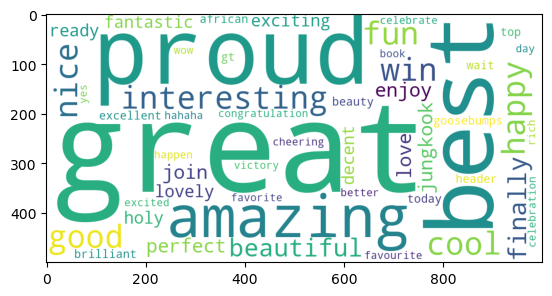

In [74]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
wordcloud = WordCloud(width = 1000, height = 500,background_color ='white',min_font_size = 10).generate(word_cloud)
plt.imshow(wordcloud)

Check the top 50 negative words

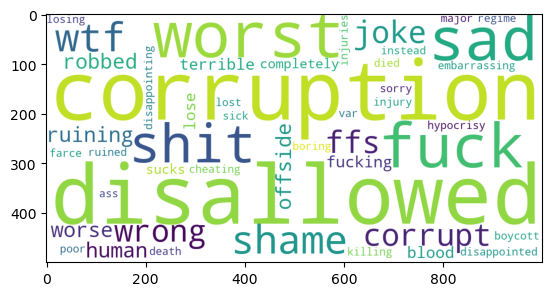

In [95]:
neg_word = get_topn_features_valence(feature_names, logreg, 'negative', topn=50)
word_cloud = " ".join(neg_word['feature'])
wordcloud = WordCloud(width = 1000, height = 500,background_color ='white',min_font_size = 10).generate(word_cloud)
plt.imshow(wordcloud)

We can see that the sentiment classified by our model is consistent with the word meaning and our perception.

#### 4.2 Error Analysis

4.2.1 Show error examples

In [76]:
# create a dataframe for testing data and the predicted labels
y_test_pred = sentiment_clf.predict(X_test)
df_test = df.loc[X_test.index]
df_test['predicted_sentiment'] = y_test_pred

In [77]:
# create a dataframe for error examples
df_test_error = df_test[df_test['Sentiment'] != df_test['predicted_sentiment']]


In [80]:
df_test_error.iloc[:14]

,Tweet,Sentiment,clean_tweet,predicted_sentiment
20322,#WorldCup2022 #Prayer - for the migrant worker...,1,for the migrant workers lgbtq community a...,0
15971,Family sweepstake. I’m doomed. #WorldCup2022 h...,0,family sweepstake i am doomed,1
17759,Now that the #WorldCup2022 is about to start. ...,0,now that the is about to start who do you re...,1
6948,RIP World Cup 👎🏼 #WorldCup2022,0,rip world cup,1
3165,1st 45 weren’t disappointing! Besides that spi...,1,st were not disappointing besides that spiri...,0
10470,Wow Ecuador strikes first! Horrible defense #W...,0,wow ecuador strikes first horrible defense,1
13849,"Fair play to @BBCSport, not holding back at al...",1,fair play to not holding back at all in criti...,0
22203,"“Until television ratings tank, teams walk off...",0,until television ratings tank teams walk off...,1
11493,"Hey #Football, just a quick thanks for driving...",1,hey just a quick thanks for driving global aw...,0
5858,Yes!!!! Go #ECU Should really be 0-2 but VAR m...,1,yes go should really be but var my arse,0


4.2.2 Interpret error examples


Emoji

In [94]:
df_test_error.loc[6948]['Tweet'], df_test_error.loc[6948]['predicted_sentiment']


('RIP World Cup 👎🏼 #WorldCup2022', 1)

We can see in this case, this tweet is mistakenly labeled as positive while it is negative. The difference is that in the clean_tweet the emoji is removed. However, this emoji here is strongly associated with negative emotions, which cannot be captured by the model as we remove all emojis. The possible solution is to find a way to keep all the emoji information, and add them into model training process.

Context changes sentiment

In [87]:
df_test_error.loc[86]['Tweet'], df_test_error.loc[86]['predicted_sentiment']

('The golden maknae killing the world cup stage. 🔥💜#BTSJUNGKOOK #WorldCup2022 #QatarWorldCup2022 https://t.co/44hbVKMT84',
 0)

In this case, the word "killing" is much likely associated with negative emotions. However, in this context, "killing" represents a positive tone. The possible solution might be to use n-grams instead of unigram therefore the model can capture more information from a set of words. 

This issue can also happen if sarcasm is involved, which can be very complicated and worth to be expored in the future. 

Other insights

In this project, only the valence of emotions (positive vs. negative) is discussed. I would like to do multiclass classification in the future where we can use more specific categories of emotions (e.g., happy, anger, disgust, ...) 